In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

with open("data/output.txt") as file:
    def process(line):
        d = json.loads(line)[1]
        sensor_measurement = d['sensor_measurement']
        measurement = d['sensor_measurement'].split(' ')
        d['sensor_type'] = measurement[0]
        if d['sensor_type'] == 'L':
            d['meas_x'] = float(measurement[1])
            d['meas_y'] = float(measurement[2])
        elif d['sensor_type'] == 'R':
            rho = float(measurement[1])
            phi = float(measurement[2])
            rho_dot = float(measurement[3])            
            d['meas_rho'] = rho
            d['meas_phi'] = phi
            d['meas_rhodot'] = rho_dot
            d['meas_x'] = rho * np.cos(phi)
            d['meas_y'] = rho * np.sin(phi)
        del d['sensor_measurement']
        return d
    
    data = [
        process(line) for line in file.readlines()
    ]
    

df = pd.DataFrame(data)
# df.head()

In [2]:
(px_target, py_target, vx_target, vy_target) = (0.09, 0.10, 0.40, 0.30)

total_rows = df.shape[0]
bad_x_rows = len(df[df['rmse_x'] > px_target].index)
bad_y_rows = len(df[df['rmse_y'] > py_target].index)
bad_vx_rows = len(df[df['rmse_vx'] > vx_target].index)
bad_vy_rows = len(df[df['rmse_vy'] > vy_target].index)

epsilon_above_95 = len(df[df['nis_epsilon'] > 7.815].index)


print("Percentage of rows not meeting RMSE_x criterion: ", '{:.2f}'.format(bad_x_rows / total_rows * 100.), "%")
print("Percentage of rows not meeting RMSE_y criterion: ", '{:.2f}'.format(bad_y_rows / total_rows * 100.), "%")
print("Percentage of rows not meeting RMSE_vx criterion: ", '{:.2f}'.format(bad_vx_rows / total_rows * 100.), "%")
print("Percentage of rows not meeting RMSE_vy criterion: ", '{:.2f}'.format(bad_vy_rows / total_rows * 100.), "%")

print("Percentage of measurements above NIS 95% criterion: ", '{:.2f}'.format(epsilon_above_95 / total_rows * 100.), "%")


print("Final RMSE_x value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_x']), ' < {:.3f}'.format(px_target))
print("Final RMSE_y value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_y']), ' < {:.3f}'.format(py_target))
print("Final RMSE_vx value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_vx']), ' < {:.3f}'.format(vx_target))
print("Final RMSE_vy value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_vy']), ' < {:.3f}'.format(vy_target))

Percentage of rows not meeting RMSE_x criterion:  4.61 %
Percentage of rows not meeting RMSE_y criterion:  0.20 %
Percentage of rows not meeting RMSE_vx criterion:  64.13 %
Percentage of rows not meeting RMSE_vy criterion:  77.15 %
Percentage of measurements above NIS 95% criterion:  3.61 %
Final RMSE_x value:  0.075  < 0.090
Final RMSE_y value:  0.082  < 0.100
Final RMSE_vx value:  0.331  < 0.400
Final RMSE_vy value:  0.285  < 0.300


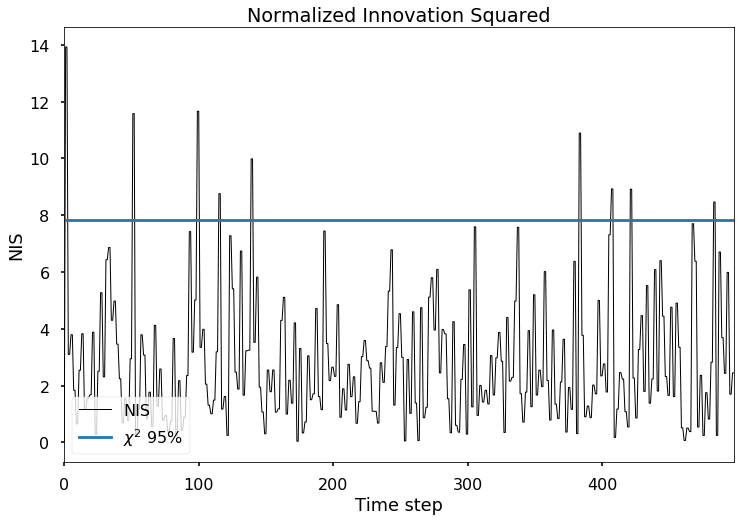

In [3]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(figsize=(12, 8))

df.plot(kind='line', y='nis_epsilon', color='black', linewidth=1, ax=ax, label="NIS")

x = np.arange(df.shape[0])
y = np.ones(df.shape[0])
ax.plot(x, y * 7.815, label="$\chi^2$ 95%")
ax.set(title='Normalized Innovation Squared', xlabel='Time step', ylabel='NIS')
ax.legend(loc='lower left', scatterpoints=1, markerscale=5)

In [4]:
df_laser = df[df['sensor_type'] == 'L']
df_radar = df[df['sensor_type'] == 'R']

def createPlot():
    fig, ax = plt.subplots(figsize=(12, 8))

    df.plot(kind='scatter', x='estimate_x', y='estimate_y', xerr='rmse_x', yerr='rmse_y', marker='^', s=2, color='green', ax=ax, label='Kalman Belief')
    df.plot(kind='line', x='gt_x', y='gt_y', color='black', linewidth=0.5, ax=ax, label="Ground Truth")

    df_laser.plot(kind='scatter', x='meas_x', y='meas_y', marker='o', s=10, color='red', ax=ax, label='Laser Measurements')
    df_radar.plot(kind='scatter', x='meas_x', y='meas_y', marker='o', s=10, color='blue', ax=ax, label='Radar Measurements')
    
    return fig, ax

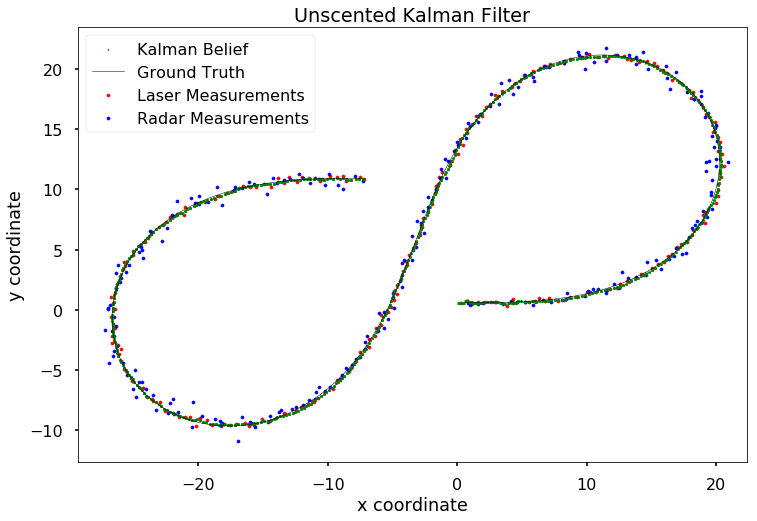

In [5]:
fig, ax = createPlot()
ax.set_xlim(1.1 * np.min(df['estimate_x']), 1.1 * np.max(df['estimate_x']))
ax.set(title='Unscented Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig1.png')

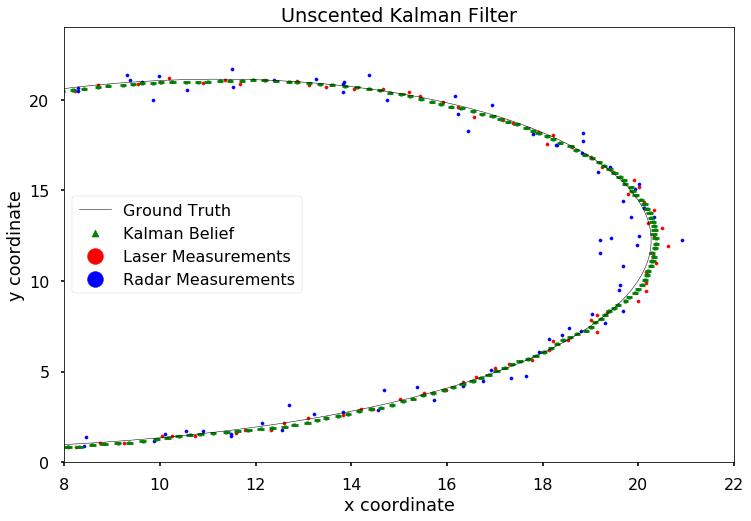

In [6]:
fig, ax = createPlot()
ax.set_xlim(8, 22)
ax.set_ylim(0, 24)
ax.legend(loc='center left', scatterpoints=1, markerscale=5)
ax.set(title='Unscented Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig2.png')

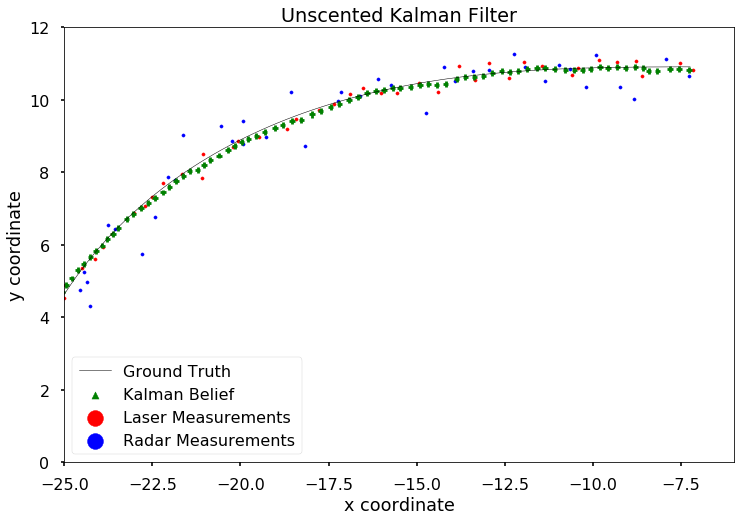

In [7]:
fig, ax = createPlot()
ax.set_xlim(-25, -6)
ax.set_ylim(0, 12)
ax.legend(loc='lower left', scatterpoints=1, markerscale=5)
ax.set(title='Unscented Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig3.png')

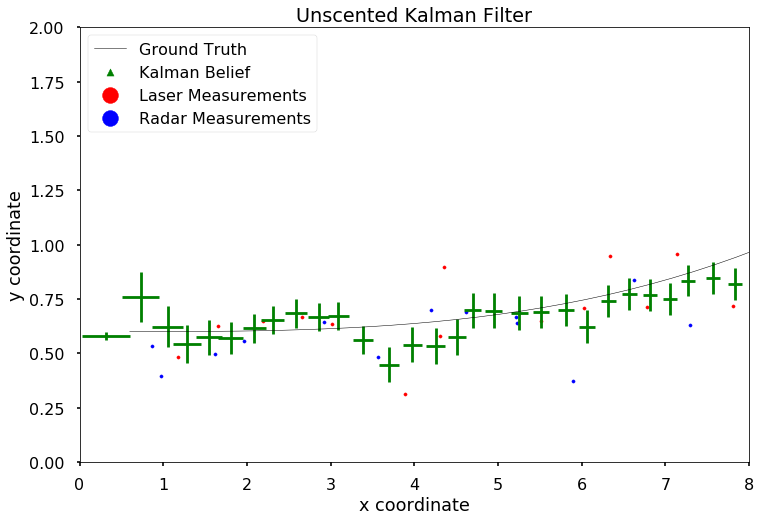

In [8]:
# First region, high error, linear path
fig, ax = createPlot()
ax.set_xlim(0, 8)
ax.set_ylim(0, 2)
ax.legend(loc='upper left', scatterpoints=1, markerscale=5)
ax.set(title='Unscented Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig4.png')